# Introduction

---

# Importing Libraries

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumor-mri-images/README.dataset.txt
/kaggle/input/brain-tumor-mri-images/README.roboflow.txt
/kaggle/input/brain-tumor-mri-images/valid/no_tumor/image-6-_jpg.rf.a2a1697bd5fec46e657e7eec28e30131.jpg
/kaggle/input/brain-tumor-mri-images/valid/no_tumor/image-132-_jpg.rf.f48f97e81621d43dacbec482bd18db5e.jpg
/kaggle/input/brain-tumor-mri-images/valid/no_tumor/image-113-_jpg.rf.cec3a88873e0cf15e81da706cc985680.jpg
/kaggle/input/brain-tumor-mri-images/valid/no_tumor/image-25-_jpg.rf.29bece8aeffef3d089d0f39650db2708.jpg
/kaggle/input/brain-tumor-mri-images/valid/no_tumor/image-45-_jpg.rf.41b82ba1258f420c267c2498f94a6667.jpg
/kaggle/input/brain-tumor-mri-images/valid/no_tumor/image-139-_jpg.rf.31536cf9ab1e4cc7fdf26ff7e481c6fa.jpg
/kaggle/input/brain-tumor-mri-images/valid/no_tumor/image-320-_jpg.rf.1f44ffc91cc0e97a3cc140782d34d85c.jpg
/kaggle/input/brain-tumor-mri-images/valid/no_tumor/image-60-_jpg.rf.14252501273a7af6c0ae261f7a284b68.jpg
/kaggle/input/brain-tumor-mri-images

---

# Color

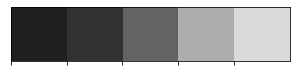

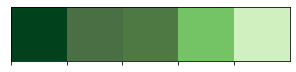

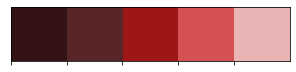

In [48]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [49]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [50]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-mri-images','train',i)
    for j in enumerate(os.listdir(folderPath)):
        if j[0] == 2250:
            break
        img = cv2.imread(os.path.join(folderPath,j[1]))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-mri-images','test',i)
    for j in enumerate(os.listdir(folderPath)):
        if j[0] == 500:
            break
        img = cv2.imread(os.path.join(folderPath,j[1]))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

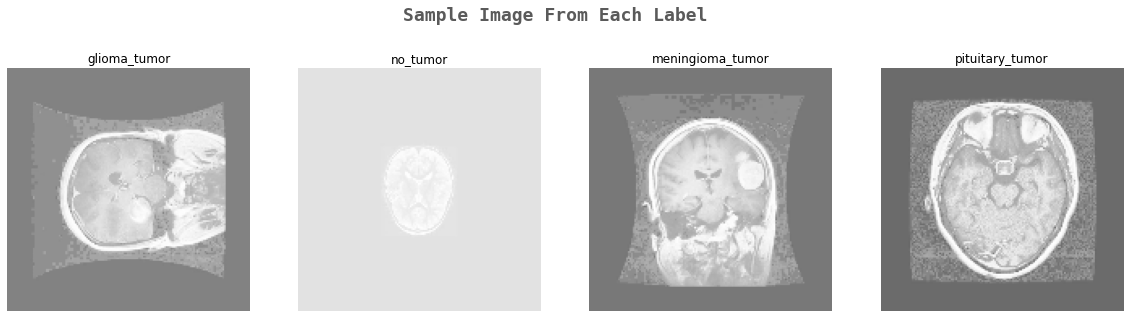

In [51]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

(<matplotlib.image.AxesImage at 0x7a60a2c48690>, 'glioma_tumor')

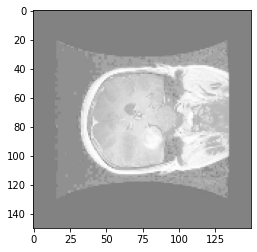

In [52]:
plt.imshow(X_train[0]), y_train[0]

(<matplotlib.image.AxesImage at 0x7a60a2bcde90>, 'glioma_tumor')

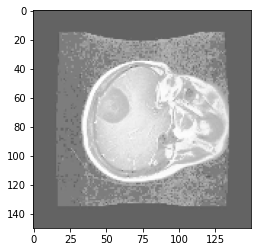

In [53]:
plt.imshow(X_train[10]), y_train[10]

In [54]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [55]:
X_train.shape

(10377, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [57]:
for i in y_train:
    print(i)
    break

meningioma_tumor


Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [58]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [59]:
y_test[0]

array([1., 0., 0., 0.], dtype=float32)

In [60]:
tf.__version__

'2.4.1'

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [61]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [62]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [63]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 150, 150, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 150, 150, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

We finally compile our model.

In [64]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [65]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [66]:
X_train.shape, y_train.shape

((9339, 150, 150, 3), (9339, 4))

In [67]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
263/263 [==============================] - 42s 126ms/step - loss: 0.5169 - accuracy: 0.8044 - val_loss: 0.3102 - val_accuracy: 0.8812

Epoch 00001: val_accuracy improved from -inf to 0.88116, saving model to effnet.h5
Epoch 2/5
263/263 [==============================] - 30s 113ms/step - loss: 0.1800 - accuracy: 0.9351 - val_loss: 0.2092 - val_accuracy: 0.9261

Epoch 00002: val_accuracy improved from 0.88116 to 0.92612, saving model to effnet.h5
Epoch 3/5
263/263 [==============================] - 30s 113ms/step - loss: 0.1300 - accuracy: 0.9560 - val_loss: 0.4020 - val_accuracy: 0.8865

Epoch 00003: val_accuracy did not improve from 0.92612
Epoch 4/5
263/263 [==============================] - 29s 112ms/step - loss: 0.0865 - accuracy: 0.9698 - val_loss: 0.1155 - val_accuracy: 0.9615

Epoch 00004: val_accuracy improved from 0.92612 to 0.96146, saving model to effnet.h5
Epoch 5/5
263/263 [==============================] - 30s 113ms/step - loss: 0.0743 - accuracy: 0.9745 - val_lo

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [74]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [75]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       263
           1       0.98      0.95      0.96       258
           2       0.79      0.99      0.88       257
           3       1.00      0.97      0.98       260

    accuracy                           0.93      1038
   macro avg       0.94      0.93      0.93      1038
weighted avg       0.94      0.93      0.93      1038



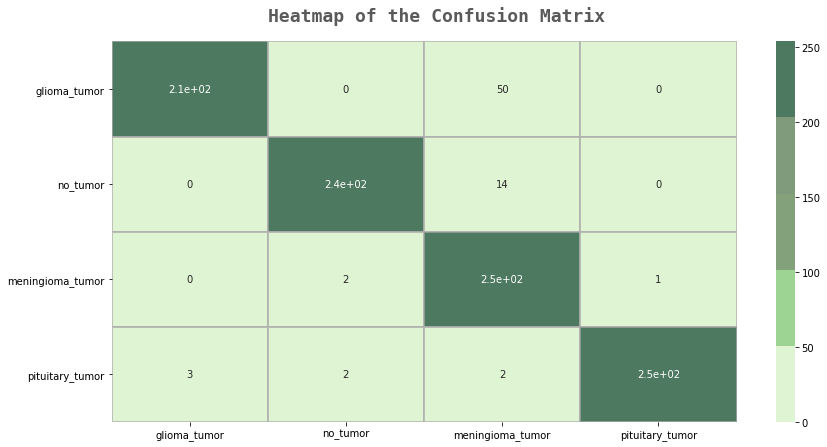

In [76]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

# Bonus Content: Widgets

I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is.<br>
Unfortunately, it doesn't work on Kaggle but you can play around with this by downloading the notebook on your machine :)

In [77]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]
    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [82]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [83]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

---

# Conclusion

In this notebook, I performed Image Classification with the help of CNN using Transfer Learning which gave an accuracy of around 98%.<br>
I also made widgets which can make predictions on an image from your local machine!

---

# <center>Thank You!